In [1]:
!pip install -U transformers

## Local Inference on GPU
Model page: https://huggingface.co/google/t5-v1_1-small

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/t5-v1_1-small)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/t5-v1_1-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-v1_1-small")

model.config.num_beams = 4
model.config.num_return_sequences = 1
model.config.length_penalty = 1.0
model.config.no_repeat_ngram_size = 3


In [3]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
def preprocess_function(example):

    input_text = "summarize: " + example["article"]
    target_text = example["highlights"]


    model_inputs = tokenizer(
        input_text,
        max_length=384,
        truncation=True,
        padding="max_length"
    )


    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_text,
            max_length=96,
            truncation=True,
            padding="max_length"
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenized_dataset = ds["train"].select(range(5000)).map(preprocess_function, batched=False)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [5]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [6]:
!pip install -q evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=018b57d4e23c0e1b2fd7468d28119274733b3e95e913ec251f35d8cf800026df
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [16]:
import numpy as np
import evaluate
rouge = evaluate.load('rouge')

def _safe_ids(arr, pad_id, vocab_size=None):
    arr = np.array(arr)
    if arr.ndim == 3:
        arr = arr[:, 0, :]

    if arr.dtype.kind != 'i':
        arr = arr.astype('int64', copy=False)

    arr[arr < 0] = pad_id
    if vocab_size is not None and vocab_size > 0:
        arr = np.where(arr >= vocab_size, pad_id, arr)
    return arr

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
    vocab_size = getattr(tokenizer, 'vocab_size', None)

    if isinstance(preds, tuple):
        preds = preds[0]

    preds  = _safe_ids(preds,  pad_id, vocab_size)
    labels = np.array(labels)
    labels = np.where(labels != -100, labels, pad_id)
    labels = _safe_ids(labels, pad_id, vocab_size)

    decoded_preds  = tokenizer.batch_decode(preds.tolist(),  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

    decoded_preds  = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    return result


In [17]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    output_dir="./t5-small-cnn-summarizer",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=True,
    report_to="none",
    generation_max_length=128,
    fp16=False
)

In [9]:
val_dataset = ds["validation"].select(range(50))
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=False)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4006: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [10]:
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-1855562264.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [11]:
import torch
torch.cuda.empty_cache()

In [12]:
trainer.train()

Step,Training Loss
100,21.809200
200,7.605400
300,4.794600
400,4.011000
500,3.458600
600,3.266900
700,3.193900
800,3.013900
900,2.975600
1000,2.933100


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3909: UserWarning: Moving the following attributes in the config to the generation config: {'num_beams': 4, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=2500, training_loss=3.9356489624023436, metrics={'train_runtime': 592.4832, 'train_samples_per_second': 16.878, 'train_steps_per_second': 4.22, 'total_flos': 1394178785280000.0, 'train_loss': 3.9356489624023436, 'epoch': 2.0})

In [13]:
trainer.evaluate()

{'eval_loss': 1.3493353128433228,
 'eval_rouge1': 30.4422,
 'eval_rouge2': 10.3032,
 'eval_rougeL': 20.9202,
 'eval_rougeLsum': 21.0257,
 'eval_runtime': 19.0367,
 'eval_samples_per_second': 2.626,
 'eval_steps_per_second': 0.683,
 'epoch': 2.0}

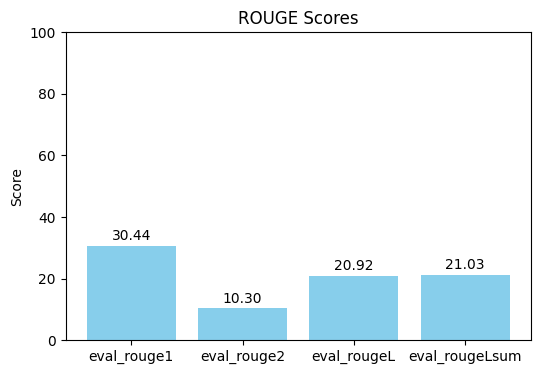

In [14]:
import matplotlib.pyplot as plt

metrics = {
    'eval_loss': 1.3493,
    'eval_rouge1': 30.4422,
    'eval_rouge2': 10.3032,
    'eval_rougeL': 20.9202,
    'eval_rougeLsum': 21.0257
}

rouge_keys = ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum']
rouge_values = [metrics[k] for k in rouge_keys]

plt.figure(figsize=(6,4))
bars = plt.bar(rouge_keys, rouge_values, color='skyblue')
plt.ylabel('Score')
plt.ylim(0, 100)
plt.title('ROUGE Scores')

for bar, val in zip(bars, rouge_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val:.2f}', ha='center', va='bottom')

plt.show()
